# Column generation approach

## Pre-requisites

In [1]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

from src import cg, config, dataset, layers, pack, superitems, utils, warm_start

In [2]:
%matplotlib notebook
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Dataset

In [4]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.NUM_PRODUCTS,
    config.MIN_PRODUCT_WIDTH,
    config.MAX_PRODUCT_WIDTH,
    config.MIN_PRODUCT_DEPTH,
    config.MAX_PRODUCT_DEPTH,
    config.MIN_PRODUCT_HEIGHT,
    config.MAX_PRODUCT_HEIGHT,
    config.MIN_PRODUCT_WEIGHT,
    config.MAX_PRODUCT_WEIGHT,
    force_overload=False,
)
product_dataset.products.head()

,width,depth,height,weight,volume
0,160,280,233,8,10438400
1,199,269,260,11,13918060
2,187,101,283,2,5345021
3,126,149,214,2,4017636
4,248,132,280,3,9166080


<IPython.core.display.Javascript object>

In [5]:
ordered_products = 100
order = product_dataset.get_order(ordered_products)
order.head()

,id,width,depth,height,weight,volume
0,121958,193,221,371,2,15824263
1,671155,236,142,437,58,14644744
2,131932,228,139,254,26,8049768
3,365838,267,131,322,11,11262594
4,259178,253,191,580,68,28027340


<IPython.core.display.Javascript object>

In [17]:
order = pd.concat([order.sample(4)] * 5).reset_index(drop=True)
order.head()

,id,width,depth,height,weight,volume
0,191335,245,168,317,2,13047720
1,328947,177,174,226,9,6960348
2,555839,350,287,441,2,44298450
3,256840,187,144,281,12,7566768
4,191335,245,168,317,2,13047720


<IPython.core.display.Javascript object>

In [18]:
order = order.sample(100).reset_index(drop=True)
order["height"] = 400
order.head()

ValueError: Cannot take a larger sample than population when 'replace=False'

<IPython.core.display.Javascript object>

## Martello's lower bounds

In [8]:
utils.get_l0_lb(order, config.PALLET_DIMS)

1.0

<IPython.core.display.Javascript object>

In [9]:
utils.get_l1_lb(order, config.PALLET_DIMS)

(0.0, 0.0, 0.0, 0.0)

<IPython.core.display.Javascript object>

In [10]:
utils.get_l2_lb(order, config.PALLET_DIMS)

TypeError: get_l1_lb() takes 2 positional arguments but 4 were given

<IPython.core.display.Javascript object>

## Superitems

In [6]:
superitems_pool = superitems.SuperitemPool(
    order=order, pallet_dims=config.PALLET_DIMS, max_vstacked=4, not_horizontal=True
)
superitems_pool.to_dataframe()

Generating vertical superitems: 100%|██████████████████████████████████████████████████████████| 24/24 [00:00<?, ?it/s]


,width,depth,height,ids,type
0,193,221,371,[0],SingleItemSuperitem
1,236,142,437,[1],SingleItemSuperitem
2,228,139,254,[2],SingleItemSuperitem
3,267,131,322,[3],SingleItemSuperitem
4,253,191,580,[4],SingleItemSuperitem
...,...,...,...,...,...
199,173,271,994,"[15, 25, 42, 98]",VerticalSuperitem
200,206,304,1338,"[0, 12, 26, 71]",VerticalSuperitem
201,226,343,1241,"[9, 44, 69, 75]",VerticalSuperitem
202,225,382,1395,"[45, 49, 72, 87]",VerticalSuperitem


<IPython.core.display.Javascript object>

In [7]:
df = superitems_pool.to_dataframe()
df[df["type"].str.contains("Vertical")]

,width,depth,height,ids,type
100,180,64,570,"[23, 88]",VerticalSuperitem
101,218,92,546,"[37, 47]",VerticalSuperitem
102,178,98,459,"[46, 86]",VerticalSuperitem
103,190,130,443,"[80, 99]",VerticalSuperitem
104,281,100,735,"[24, 74]",VerticalSuperitem
...,...,...,...,...,...
199,173,271,994,"[15, 25, 42, 98]",VerticalSuperitem
200,206,304,1338,"[0, 12, 26, 71]",VerticalSuperitem
201,226,343,1241,"[9, 44, 69, 75]",VerticalSuperitem
202,225,382,1395,"[45, 49, 72, 87]",VerticalSuperitem


<IPython.core.display.Javascript object>

In [8]:
df = superitems_pool.to_dataframe()
df[df["type"].str.contains("Horizontal")]

,width,depth,height,ids,type


<IPython.core.display.Javascript object>

## Height groups

In [9]:
height_groups = warm_start.get_height_groups(
    superitems_pool, config.PALLET_DIMS, height_tol=50, density_tol=0.7
)
for group in height_groups:
    display(group.to_dataframe())

,width,depth,height,ids,type
0,228,139,254,[2],SingleItemSuperitem
1,143,343,297,[9],SingleItemSuperitem
2,203,154,273,[10],SingleItemSuperitem
3,167,126,274,[13],SingleItemSuperitem
4,145,271,295,[15],SingleItemSuperitem
5,228,207,292,[18],SingleItemSuperitem
6,173,179,248,[25],SingleItemSuperitem
7,245,139,292,[31],SingleItemSuperitem
8,218,54,267,[37],SingleItemSuperitem
9,226,269,279,[44],SingleItemSuperitem


,width,depth,height,ids,type
0,228,139,254,[2],SingleItemSuperitem
1,143,343,297,[9],SingleItemSuperitem
2,203,154,273,[10],SingleItemSuperitem
3,167,126,274,[13],SingleItemSuperitem
4,145,271,295,[15],SingleItemSuperitem
5,228,207,292,[18],SingleItemSuperitem
6,245,139,292,[31],SingleItemSuperitem
7,218,54,267,[37],SingleItemSuperitem
8,226,269,279,[44],SingleItemSuperitem
9,159,92,279,[47],SingleItemSuperitem


,width,depth,height,ids,type
0,143,343,297,[9],SingleItemSuperitem
1,203,154,273,[10],SingleItemSuperitem
2,167,126,274,[13],SingleItemSuperitem
3,145,271,295,[15],SingleItemSuperitem
4,228,207,292,[18],SingleItemSuperitem
5,245,139,292,[31],SingleItemSuperitem
6,218,54,267,[37],SingleItemSuperitem
7,226,269,279,[44],SingleItemSuperitem
8,159,92,279,[47],SingleItemSuperitem
9,213,188,313,[50],SingleItemSuperitem


,width,depth,height,ids,type
0,143,343,297,[9],SingleItemSuperitem
1,203,154,273,[10],SingleItemSuperitem
2,167,126,274,[13],SingleItemSuperitem
3,145,271,295,[15],SingleItemSuperitem
4,245,168,317,[17],SingleItemSuperitem
5,228,207,292,[18],SingleItemSuperitem
6,245,139,292,[31],SingleItemSuperitem
7,218,54,267,[37],SingleItemSuperitem
8,226,269,279,[44],SingleItemSuperitem
9,159,92,279,[47],SingleItemSuperitem


,width,depth,height,ids,type
0,143,343,297,[9],SingleItemSuperitem
1,203,154,273,[10],SingleItemSuperitem
2,167,126,274,[13],SingleItemSuperitem
3,145,271,295,[15],SingleItemSuperitem
4,245,168,317,[17],SingleItemSuperitem
5,228,207,292,[18],SingleItemSuperitem
6,249,237,318,[30],SingleItemSuperitem
7,245,139,292,[31],SingleItemSuperitem
8,226,269,279,[44],SingleItemSuperitem
9,159,92,279,[47],SingleItemSuperitem


,width,depth,height,ids,type
0,267,131,322,[3],SingleItemSuperitem
1,143,343,297,[9],SingleItemSuperitem
2,203,154,273,[10],SingleItemSuperitem
3,167,126,274,[13],SingleItemSuperitem
4,148,195,323,[14],SingleItemSuperitem
5,145,271,295,[15],SingleItemSuperitem
6,245,168,317,[17],SingleItemSuperitem
7,228,207,292,[18],SingleItemSuperitem
8,249,237,318,[30],SingleItemSuperitem
9,245,139,292,[31],SingleItemSuperitem


,width,depth,height,ids,type
0,267,131,322,[3],SingleItemSuperitem
1,143,343,297,[9],SingleItemSuperitem
2,148,195,323,[14],SingleItemSuperitem
3,145,271,295,[15],SingleItemSuperitem
4,245,168,317,[17],SingleItemSuperitem
5,228,207,292,[18],SingleItemSuperitem
6,249,237,318,[30],SingleItemSuperitem
7,245,139,292,[31],SingleItemSuperitem
8,273,257,325,[40],SingleItemSuperitem
9,226,269,279,[44],SingleItemSuperitem


,width,depth,height,ids,type
0,267,131,322,[3],SingleItemSuperitem
1,143,343,297,[9],SingleItemSuperitem
2,148,195,323,[14],SingleItemSuperitem
3,145,271,295,[15],SingleItemSuperitem
4,245,168,317,[17],SingleItemSuperitem
5,228,207,292,[18],SingleItemSuperitem
6,249,237,318,[30],SingleItemSuperitem
7,245,139,292,[31],SingleItemSuperitem
8,231,176,329,[34],SingleItemSuperitem
9,273,257,325,[40],SingleItemSuperitem


,width,depth,height,ids,type
0,267,131,322,[3],SingleItemSuperitem
1,143,343,297,[9],SingleItemSuperitem
2,148,195,323,[14],SingleItemSuperitem
3,145,271,295,[15],SingleItemSuperitem
4,245,168,317,[17],SingleItemSuperitem
5,228,207,292,[18],SingleItemSuperitem
6,249,237,318,[30],SingleItemSuperitem
7,245,139,292,[31],SingleItemSuperitem
8,231,176,329,[34],SingleItemSuperitem
9,273,257,325,[40],SingleItemSuperitem


,width,depth,height,ids,type
0,267,131,322,[3],SingleItemSuperitem
1,143,343,297,[9],SingleItemSuperitem
2,148,195,323,[14],SingleItemSuperitem
3,145,271,295,[15],SingleItemSuperitem
4,245,168,317,[17],SingleItemSuperitem
5,228,207,292,[18],SingleItemSuperitem
6,249,237,318,[30],SingleItemSuperitem
7,245,139,292,[31],SingleItemSuperitem
8,231,176,329,[34],SingleItemSuperitem
9,273,257,325,[40],SingleItemSuperitem


,width,depth,height,ids,type
0,267,131,322,[3],SingleItemSuperitem
1,143,343,297,[9],SingleItemSuperitem
2,206,212,337,[12],SingleItemSuperitem
3,148,195,323,[14],SingleItemSuperitem
4,145,271,295,[15],SingleItemSuperitem
5,245,168,317,[17],SingleItemSuperitem
6,228,207,292,[18],SingleItemSuperitem
7,249,237,318,[30],SingleItemSuperitem
8,245,139,292,[31],SingleItemSuperitem
9,231,176,329,[34],SingleItemSuperitem


,width,depth,height,ids,type
0,267,131,322,[3],SingleItemSuperitem
1,143,343,297,[9],SingleItemSuperitem
2,206,212,337,[12],SingleItemSuperitem
3,148,195,323,[14],SingleItemSuperitem
4,145,271,295,[15],SingleItemSuperitem
5,245,168,317,[17],SingleItemSuperitem
6,228,207,292,[18],SingleItemSuperitem
7,249,237,318,[30],SingleItemSuperitem
8,245,139,292,[31],SingleItemSuperitem
9,241,158,342,[32],SingleItemSuperitem


,width,depth,height,ids,type
0,267,131,322,[3],SingleItemSuperitem
1,143,343,297,[9],SingleItemSuperitem
2,206,212,337,[12],SingleItemSuperitem
3,148,195,323,[14],SingleItemSuperitem
4,145,271,295,[15],SingleItemSuperitem
5,245,168,317,[17],SingleItemSuperitem
6,249,237,318,[30],SingleItemSuperitem
7,241,158,342,[32],SingleItemSuperitem
8,231,176,329,[34],SingleItemSuperitem
9,273,257,325,[40],SingleItemSuperitem


,width,depth,height,ids,type
0,267,131,322,[3],SingleItemSuperitem
1,206,212,337,[12],SingleItemSuperitem
2,148,195,323,[14],SingleItemSuperitem
3,245,168,317,[17],SingleItemSuperitem
4,202,210,349,[26],SingleItemSuperitem
5,249,237,318,[30],SingleItemSuperitem
6,241,158,342,[32],SingleItemSuperitem
7,231,176,329,[34],SingleItemSuperitem
8,273,257,325,[40],SingleItemSuperitem
9,186,378,351,[45],SingleItemSuperitem


,width,depth,height,ids,type
0,267,131,322,[3],SingleItemSuperitem
1,206,212,337,[12],SingleItemSuperitem
2,148,195,323,[14],SingleItemSuperitem
3,245,168,317,[17],SingleItemSuperitem
4,202,210,349,[26],SingleItemSuperitem
5,249,237,318,[30],SingleItemSuperitem
6,241,158,342,[32],SingleItemSuperitem
7,231,176,329,[34],SingleItemSuperitem
8,273,257,325,[40],SingleItemSuperitem
9,186,378,351,[45],SingleItemSuperitem


,width,depth,height,ids,type
0,193,221,371,[0],SingleItemSuperitem
1,267,131,322,[3],SingleItemSuperitem
2,206,212,337,[12],SingleItemSuperitem
3,148,195,323,[14],SingleItemSuperitem
4,202,210,349,[26],SingleItemSuperitem
5,241,158,342,[32],SingleItemSuperitem
6,231,176,329,[34],SingleItemSuperitem
7,273,257,325,[40],SingleItemSuperitem
8,186,378,351,[45],SingleItemSuperitem
9,287,157,333,[53],SingleItemSuperitem


,width,depth,height,ids,type
0,193,221,371,[0],SingleItemSuperitem
1,206,212,337,[12],SingleItemSuperitem
2,202,210,349,[26],SingleItemSuperitem
3,241,158,342,[32],SingleItemSuperitem
4,231,176,329,[34],SingleItemSuperitem
5,186,378,351,[45],SingleItemSuperitem
6,287,157,333,[53],SingleItemSuperitem
7,244,312,333,[54],SingleItemSuperitem
8,239,159,354,[61],SingleItemSuperitem
9,225,93,327,[62],SingleItemSuperitem


,width,depth,height,ids,type
0,193,221,371,[0],SingleItemSuperitem
1,206,212,337,[12],SingleItemSuperitem
2,202,210,349,[26],SingleItemSuperitem
3,241,158,342,[32],SingleItemSuperitem
4,231,176,329,[34],SingleItemSuperitem
5,186,378,351,[45],SingleItemSuperitem
6,287,157,333,[53],SingleItemSuperitem
7,244,312,333,[54],SingleItemSuperitem
8,239,159,354,[61],SingleItemSuperitem
9,241,231,350,[67],SingleItemSuperitem


,width,depth,height,ids,type
0,193,221,371,[0],SingleItemSuperitem
1,206,212,337,[12],SingleItemSuperitem
2,202,210,349,[26],SingleItemSuperitem
3,241,158,342,[32],SingleItemSuperitem
4,186,378,351,[45],SingleItemSuperitem
5,287,157,333,[53],SingleItemSuperitem
6,244,312,333,[54],SingleItemSuperitem
7,239,159,354,[61],SingleItemSuperitem
8,241,231,350,[67],SingleItemSuperitem
9,207,282,352,[69],SingleItemSuperitem


,width,depth,height,ids,type
0,193,221,371,[0],SingleItemSuperitem
1,245,379,394,[7],SingleItemSuperitem
2,249,142,388,[8],SingleItemSuperitem
3,262,148,394,[16],SingleItemSuperitem
4,202,210,349,[26],SingleItemSuperitem
5,186,378,351,[45],SingleItemSuperitem
6,219,205,393,[57],SingleItemSuperitem
7,239,159,354,[61],SingleItemSuperitem
8,241,231,350,[67],SingleItemSuperitem
9,207,282,352,[69],SingleItemSuperitem


,width,depth,height,ids,type
0,193,221,371,[0],SingleItemSuperitem
1,245,379,394,[7],SingleItemSuperitem
2,249,142,388,[8],SingleItemSuperitem
3,262,148,394,[16],SingleItemSuperitem
4,202,210,349,[26],SingleItemSuperitem
5,186,378,351,[45],SingleItemSuperitem
6,219,205,393,[57],SingleItemSuperitem
7,239,159,354,[61],SingleItemSuperitem
8,241,231,350,[67],SingleItemSuperitem
9,207,282,352,[69],SingleItemSuperitem


,width,depth,height,ids,type
0,193,221,371,[0],SingleItemSuperitem
1,245,379,394,[7],SingleItemSuperitem
2,249,142,388,[8],SingleItemSuperitem
3,262,148,394,[16],SingleItemSuperitem
4,186,378,351,[45],SingleItemSuperitem
5,219,205,393,[57],SingleItemSuperitem
6,239,159,354,[61],SingleItemSuperitem
7,207,282,352,[69],SingleItemSuperitem
8,275,171,380,[76],SingleItemSuperitem
9,307,187,387,[77],SingleItemSuperitem


,width,depth,height,ids,type
0,193,221,371,[0],SingleItemSuperitem
1,245,379,394,[7],SingleItemSuperitem
2,249,142,388,[8],SingleItemSuperitem
3,262,148,394,[16],SingleItemSuperitem
4,304,214,406,[19],SingleItemSuperitem
5,343,263,411,[21],SingleItemSuperitem
6,243,102,406,[36],SingleItemSuperitem
7,247,133,403,[38],SingleItemSuperitem
8,340,192,413,[39],SingleItemSuperitem
9,219,205,393,[57],SingleItemSuperitem


,width,depth,height,ids,type
0,193,221,371,[0],SingleItemSuperitem
1,245,379,394,[7],SingleItemSuperitem
2,249,142,388,[8],SingleItemSuperitem
3,262,148,394,[16],SingleItemSuperitem
4,304,214,406,[19],SingleItemSuperitem
5,343,263,411,[21],SingleItemSuperitem
6,277,192,416,[28],SingleItemSuperitem
7,243,102,406,[36],SingleItemSuperitem
8,247,133,403,[38],SingleItemSuperitem
9,340,192,413,[39],SingleItemSuperitem


,width,depth,height,ids,type
0,245,379,394,[7],SingleItemSuperitem
1,249,142,388,[8],SingleItemSuperitem
2,262,148,394,[16],SingleItemSuperitem
3,304,214,406,[19],SingleItemSuperitem
4,343,263,411,[21],SingleItemSuperitem
5,277,192,416,[28],SingleItemSuperitem
6,243,102,406,[36],SingleItemSuperitem
7,247,133,403,[38],SingleItemSuperitem
8,340,192,413,[39],SingleItemSuperitem
9,307,167,422,[41],SingleItemSuperitem


,width,depth,height,ids,type
0,245,379,394,[7],SingleItemSuperitem
1,249,142,388,[8],SingleItemSuperitem
2,262,148,394,[16],SingleItemSuperitem
3,304,214,406,[19],SingleItemSuperitem
4,343,263,411,[21],SingleItemSuperitem
5,277,192,416,[28],SingleItemSuperitem
6,243,102,406,[36],SingleItemSuperitem
7,247,133,403,[38],SingleItemSuperitem
8,340,192,413,[39],SingleItemSuperitem
9,307,167,422,[41],SingleItemSuperitem


,width,depth,height,ids,type
0,236,142,437,[1],SingleItemSuperitem
1,245,379,394,[7],SingleItemSuperitem
2,249,142,388,[8],SingleItemSuperitem
3,279,180,437,[11],SingleItemSuperitem
4,262,148,394,[16],SingleItemSuperitem
5,304,214,406,[19],SingleItemSuperitem
6,343,263,411,[21],SingleItemSuperitem
7,277,192,416,[28],SingleItemSuperitem
8,243,102,406,[36],SingleItemSuperitem
9,247,133,403,[38],SingleItemSuperitem


,width,depth,height,ids,type
0,236,142,437,[1],SingleItemSuperitem
1,245,379,394,[7],SingleItemSuperitem
2,279,180,437,[11],SingleItemSuperitem
3,262,148,394,[16],SingleItemSuperitem
4,304,214,406,[19],SingleItemSuperitem
5,232,494,441,[20],SingleItemSuperitem
6,343,263,411,[21],SingleItemSuperitem
7,294,136,440,[22],SingleItemSuperitem
8,277,192,416,[28],SingleItemSuperitem
9,243,102,406,[36],SingleItemSuperitem


,width,depth,height,ids,type
0,236,142,437,[1],SingleItemSuperitem
1,245,379,394,[7],SingleItemSuperitem
2,279,180,437,[11],SingleItemSuperitem
3,262,148,394,[16],SingleItemSuperitem
4,304,214,406,[19],SingleItemSuperitem
5,232,494,441,[20],SingleItemSuperitem
6,343,263,411,[21],SingleItemSuperitem
7,294,136,440,[22],SingleItemSuperitem
8,277,192,416,[28],SingleItemSuperitem
9,243,102,406,[36],SingleItemSuperitem


,width,depth,height,ids,type
0,236,142,437,[1],SingleItemSuperitem
1,279,180,437,[11],SingleItemSuperitem
2,304,214,406,[19],SingleItemSuperitem
3,232,494,441,[20],SingleItemSuperitem
4,343,263,411,[21],SingleItemSuperitem
5,294,136,440,[22],SingleItemSuperitem
6,277,192,416,[28],SingleItemSuperitem
7,243,102,406,[36],SingleItemSuperitem
8,247,133,403,[38],SingleItemSuperitem
9,340,192,413,[39],SingleItemSuperitem


,width,depth,height,ids,type
0,236,142,437,[1],SingleItemSuperitem
1,279,180,437,[11],SingleItemSuperitem
2,304,214,406,[19],SingleItemSuperitem
3,232,494,441,[20],SingleItemSuperitem
4,343,263,411,[21],SingleItemSuperitem
5,294,136,440,[22],SingleItemSuperitem
6,277,192,416,[28],SingleItemSuperitem
7,286,162,450,[29],SingleItemSuperitem
8,243,102,406,[36],SingleItemSuperitem
9,247,133,403,[38],SingleItemSuperitem


,width,depth,height,ids,type
0,236,142,437,[1],SingleItemSuperitem
1,279,180,437,[11],SingleItemSuperitem
2,304,214,406,[19],SingleItemSuperitem
3,232,494,441,[20],SingleItemSuperitem
4,343,263,411,[21],SingleItemSuperitem
5,294,136,440,[22],SingleItemSuperitem
6,277,192,416,[28],SingleItemSuperitem
7,286,162,450,[29],SingleItemSuperitem
8,268,313,456,[33],SingleItemSuperitem
9,243,102,406,[36],SingleItemSuperitem


,width,depth,height,ids,type
0,236,142,437,[1],SingleItemSuperitem
1,279,180,437,[11],SingleItemSuperitem
2,232,494,441,[20],SingleItemSuperitem
3,343,263,411,[21],SingleItemSuperitem
4,294,136,440,[22],SingleItemSuperitem
5,277,192,416,[28],SingleItemSuperitem
6,286,162,450,[29],SingleItemSuperitem
7,268,313,456,[33],SingleItemSuperitem
8,340,192,413,[39],SingleItemSuperitem
9,307,167,422,[41],SingleItemSuperitem


,width,depth,height,ids,type
0,236,142,437,[1],SingleItemSuperitem
1,279,180,437,[11],SingleItemSuperitem
2,232,494,441,[20],SingleItemSuperitem
3,294,136,440,[22],SingleItemSuperitem
4,286,162,450,[29],SingleItemSuperitem
5,268,313,456,[33],SingleItemSuperitem
6,307,167,422,[41],SingleItemSuperitem
7,324,98,472,[48],SingleItemSuperitem
8,300,291,444,[51],SingleItemSuperitem
9,350,287,441,[56],SingleItemSuperitem


,width,depth,height,ids,type
0,236,142,437,[1],SingleItemSuperitem
1,286,158,481,[5],SingleItemSuperitem
2,318,267,483,[6],SingleItemSuperitem
3,279,180,437,[11],SingleItemSuperitem
4,232,494,441,[20],SingleItemSuperitem
5,294,136,440,[22],SingleItemSuperitem
6,286,162,450,[29],SingleItemSuperitem
7,268,313,456,[33],SingleItemSuperitem
8,363,151,487,[35],SingleItemSuperitem
9,324,98,472,[48],SingleItemSuperitem


<IPython.core.display.Javascript object>

In [10]:
# Test recursive filter function (Not working ATM)
# new_height_groups = warm_start.filter_height_groups([height_groups[0]])

<IPython.core.display.Javascript object>

## Maxrects

In [10]:
final_layer_pool = layers.LayerPool(superitems.SuperitemPool())
for spool in height_groups:
    layer_pool = warm_start.maxrects(spool, config.PALLET_DIMS, add_single=False)
    final_layer_pool.extend(layer_pool)
final_layer_pool = final_layer_pool.select_layers(
    config.PALLET_WIDTH, config.PALLET_DEPTH, min_density=0.0, max_coverage=3
)
final_layer_pool.to_dataframe()

,item,x,y,z,width,depth,height,layer
0,20,0,0,0,232,494,441,0
1,56,0,494,0,350,287,441,0
2,51,232,0,0,300,291,444,0
3,35,232,291,0,363,151,487,0
4,6,532,0,0,318,267,483,0
...,...,...,...,...,...,...,...,...
81,82,193,0,0,239,119,398,6
82,66,226,0,0,242,109,289,7
83,68,468,0,0,240,97,304,7
84,70,242,0,0,234,112,251,8


<IPython.core.display.Javascript object>

In [11]:
bin_pool = pack.BinPool(final_layer_pool, config.PALLET_DIMS)
bin_pool.to_dataframe().sort_values(["bin", "layer", "item"])

,item,x,y,z,width,depth,height,layer,bin
14,1,915,570,0,236,142,437,0,0
8,2,350,442,225,228,139,254,0,0
12,5,629,608,0,286,158,481,0,0
4,6,532,0,0,318,267,483,0,0
9,11,350,618,0,279,180,437,0,0
...,...,...,...,...,...,...,...,...,...
5,82,193,0,345,239,119,398,1,1
6,66,226,0,762,242,109,289,2,1
7,68,468,0,762,240,97,304,2,1
9,47,0,109,1089,159,92,279,3,1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


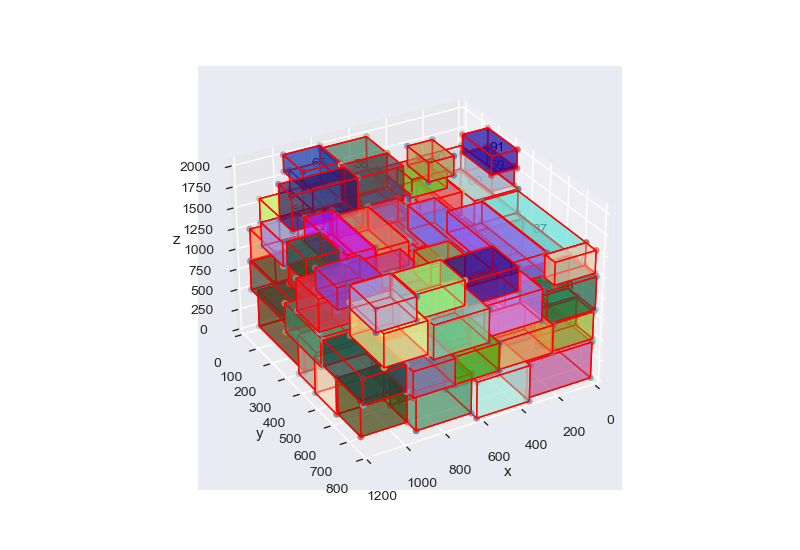

<IPython.core.display.Javascript object>


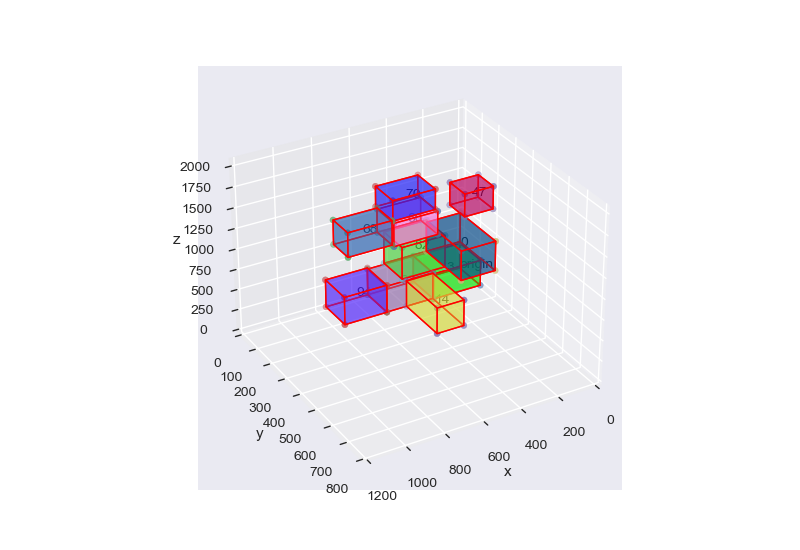

<IPython.core.display.Javascript object>

In [12]:
bin_pool.plot()
# print([b.layer_pool.get_ol() for b in bin_pool])
# print([l.superitems_pool for b in bin_pool for l in b.layer_pool])

## Column generation

- Dobbiamo passare a SP solo gli item con dual > 0?
- Dobbiamo evitare di processare layer con alpha != 1 (anche in SP no placement)?
- RMP lavora su tutti i layer, solo su quelli nuovi o su una parte?

In [14]:
bins_lbs = []
final_layer_pool = layers.LayerPool(superitems.SuperitemPool())
for spool in height_groups:
    layer_pool = warm_start.maxrects(spool, config.PALLET_DIMS, add_single=False)
    layer_pool, bins_lb = cg.column_generation(
        layer_pool,
        config.PALLET_DIMS,
        max_iter=100,
        max_stag_iters=5,
        tlim=None,
        use_maxrect=True,
    )
    final_layer_pool.extend(layer_pool)
    bins_lbs.append(bins_lb)

final_layer_pool.to_dataframe()

  4%|███▎                                                                              | 4/100 [00:00<00:06, 14.65it/s]

Solving RMP...
Duals: [297.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 289.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 312.0
Reduced cost: -307.87500000000034
Solving RMP...
Duals: [ -0. 297.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0. 289.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 312.0
Reduced cost: -290.54807692307725
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0. 289.  -0.  -0.  -0.  -0.  -0. 297.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 312.0
Reduced cost: -297.2788461538464
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0. 297.  -0.  -0.  -0.  -0.  -0.  -0.
  -0. 289.  -0.  -0.  -

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Duals: [ -0.  -0.  -0.  -0. 297.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0. 289.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 312.0
Reduced cost: -292.4807692307695
Solving RMP...
Duals: [ -0. 297.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0. 289.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Solving RMP...
Duals: [304.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 289.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 311.0
Reduced cost: -314.7073954983916
Solving RMP...
Duals:

  4%|███▎                                                                              | 4/100 [00:00<00:06, 14.97it/s]

 [ -0. 304.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
 289.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 311.0
Reduced cost: -297.3504823151118
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
 289. 304.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 311.0
Reduced cost: -290.4147909967835
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
 289. 304.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 311.0
Reduced cost: -290.4147909967835
Solving RMP...
Duals:

  2%|█▋                                                                                | 2/100 [00:00<00:05, 18.75it/s]

 [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
 289. 304.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 311.0
Reduced cost: -290.4147909967835
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
 289. 304.  -0.  -0.  -0.  -0.  -0.  -0.]
Solving RMP...
Duals: [313.  -0.  -0. 295.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 316.0
Reduced cost: -312.0822784810125
Solving RMP...
Duals: [ -0.  -0.  -0. 295.  -0.  -0.  -0.  -0.  -0. 313.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 316.0
Reduced cost: -296.26265822784796
Solving RMP...
Dua

  5%|████                                                                              | 5/100 [00:00<00:07, 12.92it/s]

Reduced cost: -296.2626582278479
Solving RMP...
Duals: [ -0.  -0.  -0. 295.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0. 313.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 316.0
Reduced cost: -296.2626582278479
Solving RMP...
Duals: [ -0.  -0.  -0. 295.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0. 313.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 316.0
Reduced cost: -296.2626582278479
Solving RMP...
Duals: [ -0.  -0.  -0. 295.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0. 313.  -0.  -0.  -0.  -0.]



  3%|██▍                                                                               | 3/100 [00:00<00:05, 19.11it/s]

Solving RMP...
Duals: [317.  -0.  -0. 295.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 316.0
Reduced cost: -316.022151898734
Solving RMP...
Duals: [ -0.  -0.  -0. 295. 317.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 316.0
Reduced cost: -296.26265822784796
Solving RMP...
Duals: [ -0.  -0.  -0. 295.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0. 317.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 316.0
Reduced cost: -300.2025316455694
Solving RMP...


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Duals: [ -0.  -0.  -0. 295. 317.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 316.0
Reduced cost: -296.26265822784796
Solving RMP...
Duals: [ -0.  -0.  -0. 295. 317.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 316.0
Reduced cost: -296.26265822784796
Solving RMP...
Duals: [ -0.  -0.  -0. 295. 317.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Solving RMP...
Duals: [318.  -0.  -0. 295.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 316.0


  2%|█▋                                                                                | 2/100 [00:00<00:06, 14.72it/s]

Reduced cost: -316.96202531645554
Solving RMP...
Duals: [ -0.  -0.  -0. 295. 318.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 316.0
Reduced cost: -297.2025316455695
Solving RMP...
Duals: [ -0.  -0.  -0. 295.  -0.  -0. 318.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 316.0
Reduced cost: -296.26265822784796
Solving RMP...
Duals: [ -0.  -0.  -0. 295.  -0.  -0. 318.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 316.0


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Reduced cost: -296.26265822784796
Solving RMP...
Duals: [ -0.  -0.  -0. 295.  -0.  -0. 318.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 316.0
Reduced cost: -296.26265822784796
Solving RMP...
Duals: [ -0.  -0.  -0. 295.  -0.  -0. 318.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Solving RMP...


  5%|████                                                                              | 5/100 [00:00<00:06, 14.67it/s]

Duals: [322.  -0.  -0.  -0. 323.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 344.0
Reduced cost: -323.27906976744276
Solving RMP...
Duals: [ -0.  -0.  -0.  -0. 323.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0. 322.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 344.0
Reduced cost: -323.27906976744293
Solving RMP...
Duals: [ -0.  -0.  -0.  -0. 323.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0. 322.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 344.0
Reduced cost: -323.27906976744293
Solving RMP...
Duals: [ -0.  -0.  -0.  -0. 323.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0. 322.]
Alpha: [1.

  3%|██▍                                                                               | 3/100 [00:00<00:05, 19.34it/s]

Duals: [ -0.  -0.  -0.  -0. 323.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0. 322.]
Solving RMP...
Duals: [325.  -0. 323.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 344.0
Reduced cost: -326.10465116279204
Solving RMP...
Duals: [ -0.  -0.  -0. 323.  -0.  -0.  -0.  -0. 325.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 344.0
Reduced cost: -324.15988372093153
Solving RMP...
Duals: [ -0.  -0.  -0. 323.  -0.  -0.  -0.  -0. 325.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 344.0
Reduced cost: -324.15988372093153
Solving RMP...
Duals: [ -

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Duals: [ -0.  -0.  -0. 323.  -0.  -0.  -0.  -0. 325.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 344.0
Reduced cost: -324.15988372093153
Solving RMP...
Duals: [ -0.  -0.  -0. 323.  -0.  -0.  -0.  -0. 325.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Solving RMP...
Duals: [329. 297.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 319.0
Reduced cost: -305.1285266457694
Solving RMP...
Duals: [ -0.  -0. 329. 297.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 319.0
Reduced cost:

  4%|███▎                                                                              | 4/100 [00:00<00:06, 15.49it/s]

 -304.1912225705343
Solving RMP...
Duals: [ -0.  -0.  -0. 297.  -0.  -0.  -0.  -0. 329.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 319.0
Reduced cost: -298.379310344829
Solving RMP...
Duals: [ -0.  -0.  -0. 297.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
 329.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 319.0
Reduced cost: -300.31661442006396
Solving RMP...


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Duals: [ -0.  -0.  -0. 297.  -0.  -0.  -0.  -0. 329.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 319.0
Reduced cost: -298.379310344829
Solving RMP...
Duals: [ -0.  -0.  -0. 297.  -0.  -0.  -0.  -0. 329.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Solving RMP...
Duals: [330.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 290.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 311.0
Reduced cost: -298.97749196141416
Solving RMP...
Duals: [ -0.  -0. 330.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0. 290.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 311.0


  4%|███▎                                                                              | 4/100 [00:00<00:06, 15.30it/s]

Reduced cost: -298.03858520900263
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 330.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0. 290.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 311.0
Reduced cost: -292.2218649517678
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0. 290. 330.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 311.0
Reduced cost: -291.2829581993562
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0. 290. 330.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 311.0
Reduced cost: -291.2829581993562
Solving RMP...


  2%|█▋                                                                                | 2/100 [00:00<00:04, 19.90it/s]

Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0. 290. 330.]
Solving RMP...
Duals: [333.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
 327.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 348.0
Reduced cost: -333.9281609195395
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 333.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0. 327.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 348.0
Reduced cost: -331.9827586206889
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 333.  -0.  -0.
  -0.  -0.  -0.  -0.  -0. 327.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 348.0
Reduced cost: -328.14655172413717
Solving RMP...


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0. 327. 333.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 348.0
Reduced cost: -331.0373563218383
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 333.  -0.
  -0.  -0.  -0.  -0.  -0. 327.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 348.0
Reduced cost: -328.14655172413717
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 333.  -0.
  -0.  -0.  -0.  -0.  -0. 327.  -0.]
Solving RMP...


  5%|████                                                                              | 5/100 [00:00<00:06, 14.31it/s]

Duals: [337.  -0.  -0.  -0. 329.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 351.0
Reduced cost: -344.7407407407416
Solving RMP...
Duals: [ -0.  -0. 337.  -0.  -0.  -0.  -0.  -0.  -0. 329.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 351.0
Reduced cost: -330.2535612535622
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 329.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0. 337.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 351.0
Reduced cost: -337.02564102564185
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 329.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0. 337.  -0.  -0.]
Alpha: [1.0,

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Solving RMP...
Duals: [ -0.  -0. 337.  -0.  -0.  -0.  -0.  -0.  -0. 329.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Solving RMP...
Duals: [342.  -0.  -0. 330.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 350.0
Reduced cost: -349.5657142857136
Solving RMP...
Duals: [ -0.  -0. 342.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0. 330.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 350.0
Reduced cost: -335.9771428571422
Solving RMP...


  5%|████                                                                              | 5/100 [00:00<00:06, 14.60it/s]

Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 342.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0. 330.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 350.0
Reduced cost: -331.0285714285708
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 342.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0. 330.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 350.0
Reduced cost: -331.0285714285708
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 342.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0. 330.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 350.0
Reduced cost: -331.0285714285708
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 342.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0. 330.]



  3%|██▍                                                                               | 3/100 [00:00<00:03, 27.78it/s]

Solving RMP...
Duals: [345.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 364.0
Reduced cost: -23.39560439560471
Solving RMP...
Duals: [ -0.  -0. 345.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 364.0
Reduced cost: -8.84065934065968
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0. 345.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 364.0
Reduced cost: -3.8901098901103275
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0. 345.]
Alpha: [1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about sel

  3%|██▍                                                                               | 3/100 [00:00<00:05, 17.89it/s]

Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0. 345.]
Alpha: [1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 364.0
Reduced cost: -0.9395604395610917
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0. 345.]
Solving RMP...
Duals: [354.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 345.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 367.0
Reduced cost: -377.32697547684006
Solving RMP...
Duals: [ -0. 354.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0. 345.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 367.0
Reduced cost: -362.8174386920989
Solving RMP...
Duals: [ -0.  -0.  -0

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

 -349.0899182561316
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 354.
  -0.  -0.  -0.  -0.  -0.  -0.  -0. 345.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 367.0
Reduced cost: -346.1989100817447
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0. 354.  -0.  -0.  -0. 345.]
Solving RMP...
Duals: [345. 363.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 367.0
Reduced cost: -371.7629427792924
Solving RMP...


  4%|███▎                                                                              | 4/100 [00:00<00:06, 13.75it/s]

Duals: [ -0.  -0.  -0.  -0. 363.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0. 345.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 367.0
Reduced cost: -359.926430517712
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 363.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0. 345.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 367.0
Reduced cost: -358.0354223433251
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 363.
  -0.  -0.  -0.  -0.  -0.  -0. 345.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 367.0
Reduced cost: -355.14441416893817
Solving RMP...


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 363.
  -0.  -0.  -0.  -0.  -0.  -0. 345.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 367.0
Reduced cost: -355.14441416893817
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 363.
  -0.  -0.  -0.  -0.  -0.  -0. 345.  -0.]
Solving RMP...
Duals: [372.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0. 345.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 365.0
Reduced cost: -346.9369863013705
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0. 372.  -0. 345.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 365.0
Reduced cost: -345.986301369864
Solving RMP...


  3%|██▍                                                                               | 3/100 [00:00<00:04, 21.49it/s]

Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0. 372.  -0. 345.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 365.0
Reduced cost: -345.986301369864
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0. 372.  -0. 345.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 365.0
Reduced cost: -345.986301369864
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0. 372.  -0. 345.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 365.0
Reduced cost: -345.986301369864
Solving RMP...


  3%|██▍                                                                               | 3/100 [00:00<00:03, 27.34it/s]

Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0. 372.  -0. 345.  -0.]
Solving RMP...
Duals: [376.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.]
Alpha: [1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 394.0
Reduced cost: -5.690355329949393
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 376.  -0.
  -0.  -0.  -0.  -0.]
Alpha: [1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 394.0
Reduced cost: -0.7766497461928237
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
 376.  -0.  -0.  -0.]
Alpha: [1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 394.0
Reduced cost: -4.7335025380709785
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 376.  -0.
  -

  4%|███▎                                                                              | 4/100 [00:00<00:03, 28.12it/s]

 -0.7766497461928237
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 376.  -0.
  -0.  -0.  -0.  -0.]
Solving RMP...
Duals: [379.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.]
Alpha: [1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 397.0
Reduced cost: -8.642317380352633
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 379.  -0.  -0.
  -0.  -0.  -0.  -0.]
Alpha: [1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 397.0
Reduced cost: -3.727959697732967
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 379.  -0.
  -0.  -0.  -0.  -0.]
Alpha: [1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 397.0
Reduced cost: -0.7707808564231422
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 379.  -0.
  -0.  -0.  -0.  -0.]
Alpha: [1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 397.0
Reduced cost: -0.7707808564231422
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 379.  -0.
  -0.  -0.  -0.  -0.]
Solving RMP...
Duals: [380.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0. 345.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 363.0
Reduced cost: -354.61707988980646
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 380.  -0.  -0.  -0.
  -0.  -0. 345.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 363.0
Reduced cost: -345.79338842975164
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Reduced cost: -353.661157024793
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 380.  -0.
  -0.  -0. 345.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 363.0
Reduced cost: -346.74931129476545
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 380.  -0.  -0.  -0.
  -0.  -0. 345.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 363.0
Reduced cost: -345.79338842975164
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 380.  -0.  -0.  -0.
  -0.  -0. 345.  -0.]
Solving RMP...


  3%|██▍                                                                               | 3/100 [00:00<00:03, 28.57it/s]

Duals: [394.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 376.  -0.
  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 393.0
Reduced cost: -394.3816793893128
Solving RMP...
Duals: [ -0. 394.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 376.  -0.
  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 393.0
Reduced cost: -376.64885496183183
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 376. 394.
  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 393.0
Reduced cost: -391.419847328244
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 394. 376.  -0.
  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, U

  3%|██▍                                                                               | 3/100 [00:00<00:03, 28.04it/s]

Duals: [ -0.  -0.  -0. 394.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 376.  -0.
  -0.  -0.  -0.]
Solving RMP...
Duals: [394.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 398.  -0.
  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 411.0
Reduced cost: -416.328467153285
Solving RMP...
Duals: [ -0. 394.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 398.
  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 411.0
Reduced cost: -394.62043795620474
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 398.
 394.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 411.0
Reduced cost: -394.62043795620497
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 398.
 394.  -0.  -0.]
Al

  3%|██▍                                                                               | 3/100 [00:00<00:03, 29.84it/s]

Reduced cost: -394.62043795620497
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 398.
 394.  -0.  -0.]
Solving RMP...
Duals: [401.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 398.  -0.
  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 414.0
Reduced cost: -401.5072463768119
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 401. 398.  -0.
  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 414.0
Reduced cost: -398.54106280193287
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 401. 398.  -0.
  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 414.0
Reduced cost: -398.54106280193287
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.

  3%|██▍                                                                               | 3/100 [00:00<00:03, 24.90it/s]


Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 401. 398.  -0.
  -0.  -0.]
Solving RMP...
Duals: [413.  -0.  -0.  -0.  -0.  -0. 406.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 424.0
Reduced cost: -413.60377358490626
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0. 413.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
 406.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 424.0
Reduced cost: -408.6415094339628
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 413.  -0.  -0.  -0.  -0.  -0.
 406.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 424.0
Reduced cost: -406.6792452830195
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 413.  -0.  -0.  -0.  -0.  -0.
 406.  -

  2%|█▋                                                                                | 2/100 [00:00<00:05, 16.41it/s]

Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 413.  -0.  -0.  -0.  -0.  -0.
 406.  -0.  -0.  -0.]
Solving RMP...
Duals: [417. 416.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 435.0
Reduced cost: -439.39080459770173
Solving RMP...
Duals: [ -0.  -0.  -0.  -0. 416.  -0.  -0. 417.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 435.0
Reduced cost: -427.58620689655226
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0. 416.  -0.  -0.  -0.  -0.  -0. 417.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 435.0
Reduced cost: -416.74252873563273
Solving RMP...


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 416.  -0. 417.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 435.0
Reduced cost: -416.7425287356327
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 416.  -0. 417.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 435.0
Reduced cost: -416.7425287356327
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 416.  -0. 417.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.]
Solving RMP...
Duals: [422.  -0.  -0.  -0.  -0.  -0. 417.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 436.0
Reduced cost: -433.54587155963384
Solving RMP...
Duals:

  3%|██▍                                                                               | 3/100 [00:00<00:04, 23.62it/s]

 [ -0.  -0.  -0.  -0. 422.  -0.  -0.  -0.  -0.  -0.  -0. 417.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 436.0
Reduced cost: -422.70183486238614
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 422.  -0. 417.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 436.0
Reduced cost: -417.7408256880742
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 422.  -0. 417.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 436.0
Reduced cost: -417.7408256880742
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 422.  -0. 417.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)

  3%|██▍                                                                               | 3/100 [00:00<00:04, 22.93it/s]

Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 422.  -0. 417.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.]
Solving RMP...
Duals: [424.  -0.  -0.  -0.  -0.  -0.  -0. 417.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 436.0
Reduced cost: -435.5366972477075
Solving RMP...
Duals: [ -0.  -0.  -0.  -0. 424.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 417.
  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 436.0
Reduced cost: -424.7018348623864
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0. 424.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 417.
  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 436.0
Reduced cost: -417.78440366972586
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Reduced cost: -417.78440366972586
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 424.  -0. 417.
  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 436.0
Reduced cost: -417.78440366972586
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 424.  -0. 417.
  -0.  -0.  -0.  -0.  -0.  -0.]
Solving RMP...
Duals: [437.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 417.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 435.0
Reduced cost: -417.7034482758626
Solving RMP...
Duals:

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

 [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 417.  -0.  -0.  -0.  -0.
  -0.  -0.  -0. 437.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 435.0
Reduced cost: -448.3908045977018
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 437.
  -0. 417.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 435.0
Reduced cost: -430.6252873563224
Solving RMP...
Duals: [ -0.  -0.  -0. 437.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0. 417.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 435.0
Reduced cost: -417.7034482758627
Solving RMP...
Duals: [ -0.  -0.  -0. 437.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0. 417.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement).

  2%|█▋                                                                                | 2/100 [00:00<00:05, 18.86it/s]

Duals: [440. 443.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 461.0
Reduced cost: -446.7635574837302
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0. 443.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0. 440.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 461.0
Reduced cost: -442.8590021691964
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 443.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 440.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 461.0
Reduced cost: -443.85900216919646
Solving RMP...


  5%|████                                                                              | 5/100 [00:00<00:08, 11.46it/s]

Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 443.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0. 437.   3.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 24.0
Reduced cost: -481.0000000000008
Solving RMP...
Duals: [ 31.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0. 443.  -0.  -0.  -0.  -0.  -0. 406.   3.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 24.0
Reduced cost: -457.00000000000057
Solving RMP...
Duals: [ 31.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0. 443. 406.   3.  -0.]



  2%|█▋                                                                                | 2/100 [00:00<00:05, 19.25it/s]

Solving RMP...
Duals: [443. 444.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 464.0
Reduced cost: -450.7112068965509
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0. 444.  -0. 443.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 464.0
Reduced cost: -446.8534482758612
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0. 444.  -0.  -0.  -0.  -0. 443.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 464.0
Reduced cost: -443.90086206896467
Solving RMP...


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0. 444.  -0.  -0.  -0. 443.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 464.0
Reduced cost: -444.90086206896467
Solving RMP...
Duals: [ -0.  -0. 147.  -0.  -0. 147.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0. 150.  -0.  -0.  -0. 147.  -0.  -0.  -0. 296.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 168.0
Reduced cost: -445.14880952381
Solving RMP...
Duals: [ -0.  -0. 437.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.   3. 441.  -0.  -0.  -0.  -0.  -0.   4.   2.]
Solving RMP...
Duals: [443. 448.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound

  5%|████                                                                              | 5/100 [00:00<00:06, 15.18it/s]

Reduced cost: -454.589632829373
Solving RMP...
Duals: [ -0.  -0.  -0. 448.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0. 443.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 463.0
Reduced cost: -450.77105831533396
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 448.
  -0.  -0.  -0.  -0. 443.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 463.0
Reduced cost: -447.81641468682443
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0. 443.  -0. 448.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 463.0
Reduced cost: -443.8617710583148
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.   4.  -0.  -0.  -0.  

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.   4.  -0.  -0.  -0.  -0.  -0.  -0.  -0.   3.
  -0.  -0.  -0. 437. 443.  -0.   4.  -0.  -0.]
Solving RMP...
Duals: [450. 448.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 469.0
Reduced cost: -461.5884861407251
Solving RMP...
Duals: [ -0.  -0.  -0. 448.  -0.  -0.  -0.  -0. 450.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 469.0


  4%|███▎                                                                              | 4/100 [00:00<00:07, 13.25it/s]

Reduced cost: -448.9317697228146
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0. 448.  -0.  -0. 450.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 469.0
Reduced cost: -457.78464818763337
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 437.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 448.  13.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 34.0
Reduced cost: -461.647058823528
Solving RMP...
Duals: [ -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.    3.5  -0.
  -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.  444.5 441.
   5.5]
Alpha: [0.0, 0.5, 0.0, 0.5, 0.5, 0.5]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Reward about selecting superitems wi

  6%|████▉                                                                             | 6/100 [00:00<00:08, 11.62it/s]

Duals: [ -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.    3.5  -0.
  -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.  444.5 441.
   5.5]
Alpha: [0.0, 0.5, 0.0, 0.5, 0.5, 0.5, 0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 24.5
Reduced cost: -461.92857142857065
Solving RMP...
Duals: [ -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.    3.5  -0.
  -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.  444.5 441.
   5.5]
Alpha: [0.0, 0.5, 0.0, 0.5, 0.5, 0.5, 0.0, 0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 24.5
Reduced cost: -461.92857142857065
Solving RMP...


  8%|██████▌                                                                           | 8/100 [00:00<00:09,  9.95it/s]

Duals: [ -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.    3.5  -0.
  -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.  444.5 441.
   5.5]
Alpha: [0.0, 0.5, 0.0, 0.5, 0.5, 0.5, 0.0, 0.0, 0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 24.5
Reduced cost: -461.92857142857065
Solving RMP...
Duals: [ -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.    3.5  -0.
  -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.  444.5 441.
   5.5]
Alpha: [0.0, 0.5, 0.0, 0.5, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 24.5
Reduced cost: -461.92857142857065
Solving RMP...


  2%|█▋                                                                                | 2/100 [00:00<00:05, 19.55it/s]

Duals: [ -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.    3.5  -0.
  -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.  444.5 441.
   5.5]
Solving RMP...
Duals: [450. 456.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 470.0
Reduced cost: -469.46808510638243
Solving RMP...
Duals: [ -0.  -0.  -0. 456.  -0. 450.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 470.0
Reduced cost: -465.65531914893563
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 450. 456.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals

  5%|████                                                                              | 5/100 [00:00<00:07, 12.32it/s]

Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0. 450.  -0.  -0.  -0. 456.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 470.0
Reduced cost: -456.84255319148883
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  15.  -0.  -0.  -0.  -0.
  -0. 441.  -0. 450.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 35.0
Reduced cost: -460.7999999999995
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  15.  -0.  -0.  -0.  -0.
  -0. 441.  -0. 450.  -0.  -0.  -0.  -0.  -0.  -0.]



  2%|█▋                                                                                | 2/100 [00:00<00:05, 18.84it/s]

Solving RMP...
Duals: [456.  -0.  -0.  -0. 459.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 475.0
Reduced cost: -475.46315789473647
Solving RMP...
Duals: [ -0.  -0. 456.  -0.  -0.  -0.  -0. 459.  -0.  -0.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 475.0
Reduced cost: -465.78736842105224
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 456.  -0.  -0.  -0. 459.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 475.0
Reduced cost: -456.8336842105259
Solving RMP...


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  16.  -0.  -0.  -0. 459.  -0.
  -0. 440.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 35.0
Reduced cost: -466.7999999999996
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  16.  -0.  -0.  -0. 459.  -0.
  -0. 440.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 35.0
Reduced cost: -466.7999999999996
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  16.  -0.  -0.  -0. 459.  -0.
  -0. 440.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Solving RMP...
Duals: [472.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 459.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 475.0
Red

  5%|████                                                                              | 5/100 [00:00<00:05, 17.61it/s]

Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 472.  -0.  -0.  -0.
  -0.  -0. 459.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 475.0
Reduced cost: -459.63999999999993
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 472.  -0.  -0.  -0.
  -0.  -0. 459.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 475.0
Reduced cost: -459.63999999999993
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 472.  -0.  -0.  -0.
  -0.  -0. 459.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 475.0
Reduced cost: -459.63999999999993
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 472.  -0.  -0.  -0.
  -0.  -0. 459.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.


  4%|███▎                                                                              | 4/100 [00:00<00:06, 15.65it/s]

Solving RMP...
Duals: [487.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 484.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 504.0
Reduced cost: -512.5932539682553
Solving RMP...
Duals: [ -0. 487.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 484.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 504.0
Reduced cost: -492.6845238095252
Solving RMP...
Duals: [ -0.  -0. 487.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 484.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.]
Alpha: [1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 504.0
Reduced cost: -487.82142857143
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 487.  -0.  20.  -0.   

  6%|████▉                                                                             | 6/100 [00:00<00:07, 12.62it/s]

Solving RMP...
Duals: [ -0.  -0.  -0. 467.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  20.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 459.]
Alpha: [0.0, 0.0, 1.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 40.0
Reduced cost: -472.34999999999906
Solving RMP...
Duals: [ -0.  -0.  -0.   4.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  20.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 459. 463.  -0.]
Alpha: [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 24.0
Reduced cost: -475.7500000000008
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 487.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 459.]
Alpha: [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 479.0
Reduced cost: -459.91231732776725
Solving RMP...


  8%|██████▌                                                                           | 8/100 [00:00<00:08, 10.54it/s]

Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 487.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 459.]
Alpha: [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 479.0
Reduced cost: -459.91231732776725
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 487.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 459.]
Alpha: [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
Reward about selecting superitems with duals ==0, Upper bound: 479.0
Reduced cost: -459.91231732776725
Solving RMP...


  9%|███████▍                                                                          | 9/100 [00:00<00:09,  9.64it/s]

Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 487.  -0.  -0.  -0.  -0.
  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 459.]


,item,x,y,z,width,depth,height,layer
0,60,0,0,0,238,345,289,0
1,87,0,345,0,197,382,268,0
2,37,0,727,0,218,54,267,0
3,49,197,345,0,188,371,257,0
4,44,238,0,0,226,269,279,0
...,...,...,...,...,...,...,...,...
3785,97,872,440,0,299,121,486,249
3786,52,872,561,0,317,110,484,249
3787,1,636,582,0,236,142,437,249
3788,46,872,671,0,178,83,195,249


<IPython.core.display.Javascript object>

In [15]:
final_layer_pool = final_layer_pool.select_layers(
    config.PALLET_WIDTH, config.PALLET_DEPTH, min_density=0.0, max_coverage=3
)

<IPython.core.display.Javascript object>

In [16]:
final_layer_pool.to_dataframe()

,item,x,y,z,width,depth,height,layer
0,20,0,0,0,232,494,441,0
1,56,0,494,0,350,287,441,0
2,21,232,0,0,343,263,411,0
3,39,232,263,0,340,192,413,0
4,51,350,455,0,300,291,444,0
...,...,...,...,...,...,...,...,...
72,36,193,119,0,243,102,406,5
73,66,226,0,0,242,109,289,6
74,68,468,0,0,240,97,304,6
75,70,242,0,0,234,112,251,7


<IPython.core.display.Javascript object>

In [17]:
np.floor(np.mean(bins_lbs) / config.PALLET_HEIGHT)

0.0

<IPython.core.display.Javascript object>

In [18]:
bin_pool = pack.BinPool(final_layer_pool, config.PALLET_DIMS)
bin_pool.to_dataframe()

,item,x,y,z,width,depth,height,layer,bin
0,20,0,0,0,232,494,441,0,0
1,56,0,494,0,350,287,441,0,0
2,21,232,0,0,343,263,411,0,0
3,39,232,263,0,340,192,413,0,0
4,51,350,455,0,300,291,444,0,0
...,...,...,...,...,...,...,...,...,...
1,36,193,119,0,243,102,406,0,1
2,66,226,0,417,242,109,289,1,1
3,68,468,0,417,240,97,304,1,1
4,70,242,0,744,234,112,251,2,1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


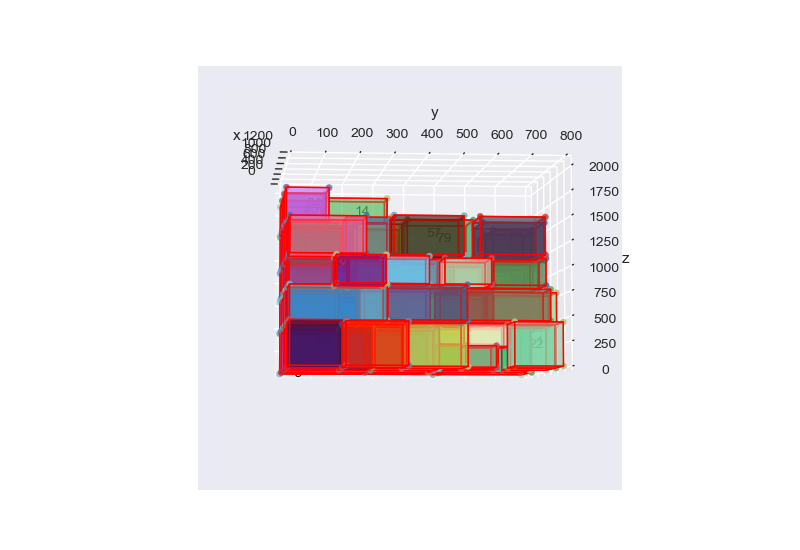

<IPython.core.display.Javascript object>


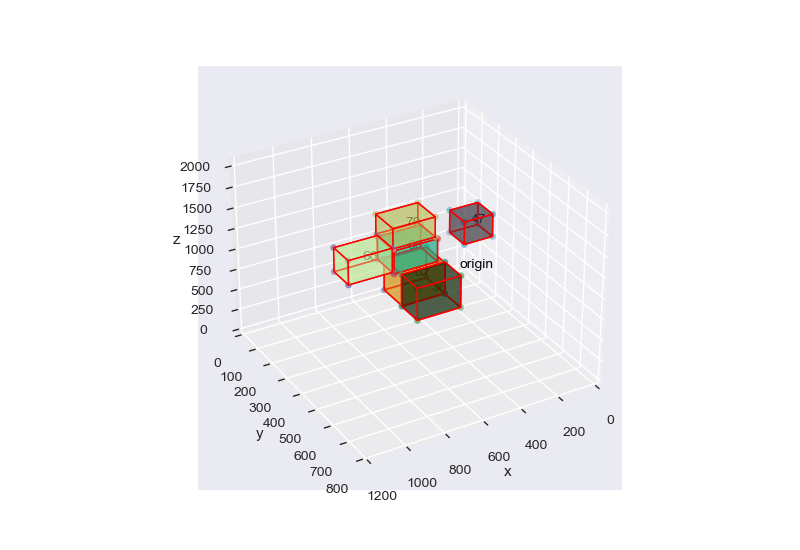

<IPython.core.display.Javascript object>

In [19]:
bin_pool.plot()

## Todo 

### Problemi in Input al modello:
- [ ] Correggere gestione superitem in Heigth groups
    - Problema riguardo stesso Item nello stesso Layer dovuto a superitem Horizontal nei 2 assi -> (Messo in pausa, per ora risolto usando solo Vertical e Single superitems)
    - Suddividere gruppi in piu gruppi 
        - Solo fra superitem con > 1 item e superitem con = 1 item
- [x] Eliminare gruppi con 1 solo item e gruppi con densita minore di 0.5
- [x] Creare Vertical Superitems consistenti alla loro dimensione principale (Da rivedere in caso di aggiunta rotazione, come tutto...)
- [x] Corretto calcolo volume Superitems e aggiunto enclosing_volume per Vertical Superitems
- [ ] Rivedere lower bound martello (L1 viene 0) (L0 viene sempre 1) (L2 non compi

### Problemi interni al modello:
- [x] Aggiunto reward in pricing_no_placement per incetivare la costruzione di layer più densi -> Con più item, quindi anche di item con Dual[i]==0, formula di reward con upper_bound = min(dual[i] !=0)
- [x] Modificato pricing placement (v2) per piazzare tutti gli item selezionati se possibile -> Molto lento con 13 item muore ma corretto rispetto a v1 che tendeva per costruzione a non piazzare tutta la sottoparte selezionata
- [x] Aggiunto maxrect placement per i nuovi layer del column generation

    
### Problemi in Output al modello:
- [ ] Aggiungere gestione Weigth a quella della Densità con qualche priorità e spiegazione annessa
- [ ] Aggiungere gestione coordinate corretta per i Vertical Superitems, centrare gli oggetti nello spazio occupato
- [ ] Controllare select_layer e aggiungere flag per utilizzare solo subset di sottoprocess per testing
- [ ] Sostituire item rimossi in fase di select_layers con altri item non piazzati, usando maxrects
- [ ] Gestione Item rimanenti
    1. Piazzare gli ultimi item con algoritmo s-shape
    2. Provare a suddividere lo spazio rimanente in alto anche di layer incompleti in "Sotto pallet" ed usare maxrect su quelli (Magari funziona meglio)
- [ ] Gestione spaziatura 
    - Spaziatura intra-layer spiegata nel paper?
        1. 2 modelli di linear programming -> Spaziatura mediante modelli per width and depth dimensions
        2. Soluzione di spostamento monodirezionale iterativa dei blocchi di un layer (Da pensare per bene come alternativa a 1)
    - Spaziatura inter-layer in altezza
         1. Controllare spazi vuoti anche in altezza al termine di tutto usando una delle 2 tecnice sopradescritte
         
### Aggiunte eventuali
- [ ] Gestione rotazione
- [ ] Oggetti fragili -> Peso + attributi particolari
